# Interpolacja Hermite'a 
## Używając metody Newtona oraz pierwszej pochodnej

In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from collections.abc import Callable
import ipympl
%matplotlib ipympl

## Generowanie wartości x

In [67]:
def generate_chebyshev_roots(n: int, a: np.float64, b: np.float64):
  return np.array([(a+b)/2 + (b-a)/2 * np.cos((2*k+1)/(2*n) * np.pi) for k  in range(n)], dtype=np.float64)

def generate_function_uniform_nodes(n: int, interval: tuple[np.float64, np.float64], func):
  a,b= interval[0], interval[1]
  xs = np.linspace(a,b,n)
  tups = []
  for x in xs:
    tups.append((x,func(x)))
  return np.array(tups)

def generate_function_chebyshev_nodes(n: int, interval: tuple[np.float64, np.float64], func):
  a,b= interval[0], interval[1]
  xs = generate_chebyshev_roots(n,a,b)
  tups = []
  for x in xs:
    tups.append((x,func(x)))
  return np.array(tups)


## Interpolacja Hermite'a

In [68]:
def hermite_divided_difference_table(nodes: np.ndarray, deriv_nodes: np.ndarray) -> np.ndarray:

  n = len(nodes)
  nodes_x = nodes[:,0]
  nodes_y = nodes[:,1]
  nodes_derivative_y = deriv_nodes[:,1]
  z = np.zeros(2 * n, dtype=np.float64) # Duplicate values for Hermite interpolation
  dp = np.zeros((2 * n, 2 * n), dtype=np.float64)  # Divided difference table

  # Fill z with duplicated x values
  for i in range(n):
    z[2 * i] = nodes_x[i]
    z[2 * i + 1] = nodes_x[i]

  # Fill in function values
  for i in range(n):
    dp[2 * i, 0] = nodes_y[i]
    dp[2 * i + 1, 0] = nodes_y[i]
    dp[2 * i + 1, 1] = nodes_derivative_y[i]  # First derivative constraint
    if i != 0:
      dp[2 * i, 1] = (dp[2 * i, 0] - dp[2 * i - 1, 0]) / (z[2 * i] - z[2 * i - 1])

  for i in range(2,2*n):
    for j in range(2,i+1):
      dp[i,j] = (dp[i,j-1] - dp[i-1,j-1])/(z[i] - z[i-j])

  return z, dp


def get_hermite_interpolation_func(nodes: np.ndarray, deriv_nodes: np.ndarray) -> Callable[[float], float]:
    
    nodes_x, dp = hermite_divided_difference_table(nodes, deriv_nodes)
    
    def func_hermite(x: float) -> float:
      n = len(nodes_x)
      result = dp[n-1,n-1]
      for i in range(n-2,-1,-1):
        result = result * (x-nodes_x[i]) + dp[i,i]
      return result
    
    return func_hermite


## Wizualizacja

In [69]:
def plot_function(
    x_values: np.ndarray[np.float64], 
    func: Callable[[np.float64], np.float64], 
    nodes: np.ndarray[(np.float64, np.float64)] | None = None,
    x_lim: tuple[float, float] | None = None,
    y_lim: tuple[float, float] | None = None,
    x_scale: str = 'linear',
    y_scale: str = 'linear'
):
    y_values = np.array([func(x) for x in x_values])

    plt.plot(x_values, y_values, label='Lagrange Interpolation')
    if nodes is not None:
        plt.scatter(nodes[:, 0], nodes[:, 1], color='red', label='Data Points')
    
    plt.xscale(x_scale)
    plt.yscale(y_scale)
    
    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Function visualisation')


## Przykładowe użycie

In [73]:
m = 5
k = 0.5
interval = (-5,5)
N = 20

func = lambda x: x**2 - m*np.cos((np.pi * x) / k)
func_derivative = lambda x: 2*x + ((m * np.pi) / k) * np.sin((np.pi * x) / k) 

In [74]:
nodes_linear = generate_function_uniform_nodes(N,interval, func)
nodes_derivative_linear = generate_function_uniform_nodes(N,interval, func_derivative)
hermite_linear = get_hermite_interpolation_func(nodes_linear, nodes_derivative_linear)

nodes_chebyshev = generate_function_chebyshev_nodes(N,interval, func)
nodes_derivative_chebyshev= generate_function_chebyshev_nodes(N,interval, func_derivative)

hermite_chebyshev= get_hermite_interpolation_func(nodes_linear, nodes_derivative_linear)



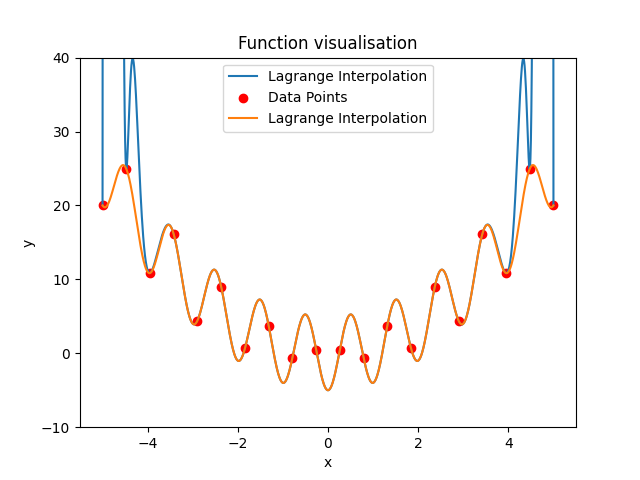

In [75]:
# plt.clf()
# plot_function(np.linspace(interval[0], interval[1], 1000), hermite_linear, nodes_linear, y_lim=(-10,40))
# plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10,40))
# plt.show()

plt.clf()
plot_function(np.linspace(interval[0], interval[1], 1000), hermite_chebyshev, nodes_linear, y_lim=(-10,40))
plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10,40))
plt.show()